# Heart Disease prediction
- [Data](./data/heart.csv) is from [Kaggle](https://www.kaggle.com/datasets/johnsmith88/heart-disease-dataset)
- Original dataset is from [UCI Machine Learning Repository](https://archive-beta.ics.uci.edu/ml/datasets/heart+disease)

<details>
<summary><b>Additional Information</b></summary>
<p><a href="./data/heart.csv">heart.csv</a> is training data with id as index.</p>
<p>This database contains 76 attributes, but all published experiments refer to using a subset of 14 of them.  In particular, the Cleveland database is the only one that has been used by ML researchers to
 this date.  The "goal" field refers to the presence of heart disease in the patient.  It is integer valued from 0 (no presence) to 4. Experiments with the Cleveland database have concentrated on simply attempting to distinguish presence (values 1,2,3,4) from absence (value 0).</p>
</details>

<details>
<summary><b>Columns Description</b></summary>
<p>

1. **age**: Age in years
2. **Sex**: sex (1 = male; 0 = female)
3. **cp**:  chest pain type
- 1: typical angina
- 2: atypical angina
- 3: non-anginal pain
- 4: asymptomatic
4. **trestbps**: resting blood pressure (in mm Hg on admission to the hospital)
5. **chol**: serum cholestoral in mg/dl
6. **fbs**:  (fasting blood sugar > 120 mg/dl)  (1 = true; 0 = false)
7. **restecg**: resting electrocardiographic results
- 0: normal
- 1: having ST-T wave abnormality (T wave inversions and/or ST elevation or depression of > 0.05 mV)
- 2: showing probable or definite left ventricular hypertrophy by Estes' criteria
8. **thalach**: maximum heart rate achieved
9.  **exang**:  exercise induced angina (1 = yes; 0 = no)
10. **oldpeak**: ST depression induced by exercise relative to rest
11. **slope**: the slope of the peak exercise ST segment
- 1: upsloping
- 2: flat
- 3: downsloping
12. **ca**: number of major vessels (0-3) colored by flourosopy
13. **thal**: 3 = normal; 6 = fixed defect; 7 = reversable defect

***Target Variable***
14. **num**: diagnosis of heart disease (angiographic disease status)
- 0: < 50% diameter narrowing
- 1: > 50% diameter narrowing
</p>
</details>

## Idea
Use *logistic regression* to predict heart disease.

## Approach
1. Import required libraries
2. Load data
3. Feature Selection
4. EDA
5. Feature Scaling
6. Use *Logistic Regression*
7. Fit the data
8.  Predict *target* on sample test data

## 1. Importing required libraries

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from logistic_regression import LogisticRegression
from sklearn.feature_selection import mutual_info_classif
plt.style.use("seaborn")

## 2. Loading data

In [2]:
train_data = pd.read_csv("./data/train.csv")
test_data = pd.read_csv("./data/test.csv")
train_data.head()

age  sex  cp  trestbps  chol  fbs  restecg  thalach  exang  oldpeak  slope  \
0   42    1   3       148   244    0        0      178      0      0.8      2   
1   66    0   2       146   278    0        0      152      0      0.0      1   
2   53    1   2       130   246    1        0      173      0      0.0      2   
3   58    0   0       100   248    0        0      122      0      1.0      1   
4   53    1   0       123   282    0        1       95      1      2.0      1   

   ca  thal  target  
0   2     2       1  
1   1     2       1  
2   3     2       1  
3   0     2       1  
4   2     3       0

## 3. Feature Selection
- Using `mutual_info_classif()` function to get most important features
- Selecting common features from them

In [3]:
def get_mi_scores(X:pd.DataFrame, Y:pd.Series, discrete_features:list[bool]) -> pd.Series:
    """
    Use `mutual_info_classif` to find
    mutual information between features & target.
    Args:
        X: input data
        Y: target variable
        discrete_features: a list of bool values represent discerete/continuous features.
    Returns:
        mi_scores: A series of MI scores in descending order.
    """
    X = X.copy()
    mi_scores = mutual_info_classif(X, Y, discrete_features=discrete_features, random_state=0)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns).sort_values(ascending=False)
    return mi_scores

In [4]:
discrete_features = {}
for i in train_data.columns[:-1]:
    discrete_features[i] = len(train_data[i].value_counts()) <= 5
discrete_features

{'age': False,
 'sex': True,
 'cp': True,
 'trestbps': False,
 'chol': False,
 'fbs': True,
 'restecg': True,
 'thalach': False,
 'exang': True,
 'oldpeak': False,
 'slope': True,
 'ca': True,
 'thal': True}

In [5]:
mi_scores = get_mi_scores(train_data[discrete_features.keys()], train_data["target"], discrete_features=list(discrete_features.values()))
mi_scores

chol        0.223058
oldpeak     0.158173
thalach     0.151674
cp          0.140340
thal        0.130107
ca          0.128182
exang       0.097918
slope       0.075552
trestbps    0.069456
age         0.066960
sex         0.042649
restecg     0.021491
fbs         0.000666
Name: MI Scores, dtype: float64

In [6]:
features = ["chol", "thalach", "cp", "exang", "age", "sex", "trestbps", "fbs"]
train_data[features + ["target"]].head()

chol  thalach  cp  exang  age  sex  trestbps  fbs  target
0   244      178   3      0   42    1       148    0       1
1   278      152   2      0   66    0       146    0       1
2   246      173   2      0   53    1       130    1       1
3   248      122   0      0   58    0       100    0       1
4   282       95   0      1   53    1       123    0       0

In [7]:
X = train_data[features].copy(True)
Y = train_data["target"].copy(True)
X_test = test_data[features].copy(True)

## 4. Exploratory Data Analysis

In [8]:
has_heart_disease = train_data["target"]==1
plt.title("Heart Disease by Age")
plt.xlabel("Age")
plt.ylabel("Count")
plt.hist(train_data[has_heart_disease]["age"], bins=20, alpha=0.5, color="red", label="Presence")
plt.axvline(train_data[has_heart_disease]["age"].mean(), color="blue", label="Avg. Age Presence", linewidth=3)

plt.hist(train_data[~has_heart_disease]["age"], bins=20, alpha=0.5, color="green", label="Absence")
plt.axvline(train_data[~has_heart_disease]["age"].mean(), color="purple", label="Avg. Age Absence", linewidth=3)
plt.legend()

In [9]:
corr = train_data[features + ["target"]].corr()
plt.figure(figsize=(8, 6))
sns.heatmap(corr, annot=True)

<AxesSubplot:>

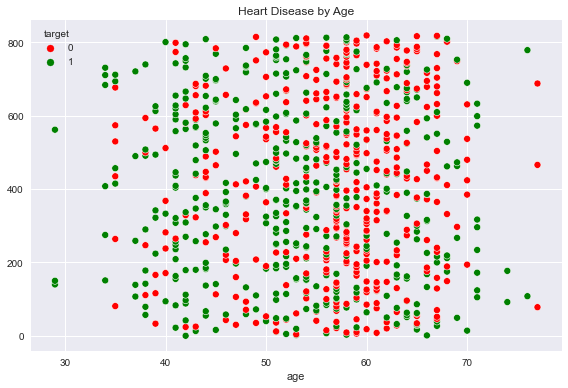

In [10]:
plt.title("Heart Disease by Age")
sns.scatterplot(x=X["age"], y=X.index, hue=Y, palette=["red", "green"])
plt.tight_layout()

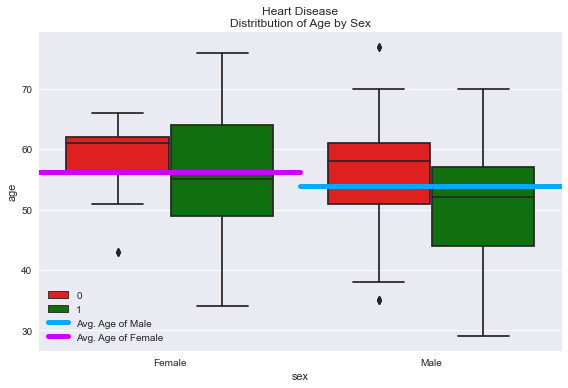

In [11]:
plt.title("Heart Disease\nDistritbution of Age by Sex")
sns.boxplot(x=X["sex"], y=X["age"], hue=Y, palette=["red", "green"])
plt.xticks([0, 1], ["Female", "Male"])

plt.axhline(X[X["sex"]==1]["age"].mean(), color="#00AAFF", label="Avg. Age of Male", xmin=0.5, linewidth=5)
plt.axhline(X[X["sex"]==0]["age"].mean(), color="#CC00FF", label="Avg. Age of Female", xmin=0, xmax=0.5, linewidth=5)

plt.legend(loc="lower left")
plt.tight_layout()

- Males 50+ yrs have high chance of heart disease
- Females 55+ yrs have high chance of heart disease

In [12]:
plt.title("Heart Disease\nDistritbution of Cholesterol by Sex")
sns.boxplot(x=X["sex"], y=X["chol"], hue=Y, palette=["red", "green"])

plt.ylabel("Cholesterol")
plt.xticks([0, 1], ["Female", "Male"])


plt.axhline(X[X["sex"]==1]["chol"].mean(), color="#00AAFF", label="Avg. Cholesterol of Male", xmin=0.5, linewidth=5)
plt.axhline(X[X["sex"]==0]["chol"].mean(), color="#CC00FF", label="Avg. Cholesterol of Female", xmin=0, xmax=0.5, linewidth=5)

plt.legend()
plt.tight_layout()

- Males with cholesterol 250+ have high chance of heart disease
- Females with cholesterol 260+ have high chance of heart disease

In [13]:
X.head()

chol  thalach  cp  exang  age  sex  trestbps  fbs
0   244      178   3      0   42    1       148    0
1   278      152   2      0   66    0       146    0
2   246      173   2      0   53    1       130    1
3   248      122   0      0   58    0       100    0
4   282       95   0      1   53    1       123    0

In [14]:
# sns.violinplot(x=X["cp"], y=X["age"], hue=Y, palette=["red", "#00FFCC"], )
g = sns.catplot(x="cp", y="age", col="sex", hue="target", data=train_data, kind="box", palette=["red", "#00FFCC"])
g.fig.suptitle("Heart Disease\nDistribution of Chest Pain by Sex")
g.set_xticklabels(["typical\nangina", "atypical\nangina", "non-anginal", "asymptomatic"])
g.fig.supxlabel("Chest Pain")
g.axes[0][0].set_title("Female")
g.axes[0][1].set_title("Male")
g.set_xlabels("")
g.tight_layout()

- Females having typical angina Chest pain have more chance of heart disease
- Males having non-anginal and asymptomatic pain have more chance of heart disease

## 5. Feature Scaling
- Using `Z-score normalization` to scale features

In [15]:
def standardization(X: pd.DataFrame) -> tuple[pd.DataFrame | float]:
    """
    Normalized data using Z-score normalization
    Args:
        X: data
    Returns:
        norm_data: normalized data
        mu (μ): mean of each feature
        sigma (σ): standard deviation of each feature
    """
    # calculating mean of each feature
    mu = np.mean(X, axis=0)
    # calculating standard deviation of each feature
    sigma = np.std(X, axis=0)
    # normalizing data
    norm_data = (X - mu) / sigma

    return norm_data, mu, sigma

In [16]:
X_scaled, mu, sigma = standardization(X)
X_scaled.head()

chol   thalach        cp     exang       age       sex  trestbps  \
0 -0.058677  1.258177  1.977486 -0.720082 -1.405034  0.648956  0.947890   
1  0.595166  0.128065  1.011710 -0.720082  1.262700 -1.540937  0.832696   
2 -0.020216  1.040848  1.011710 -0.720082 -0.182322  0.648956 -0.088854   
3  0.018246 -1.175910 -0.919843 -0.720082  0.373456 -1.540937 -1.816760   
4  0.672089 -2.349489 -0.919843  1.388730 -0.182322  0.648956 -0.492032   

        fbs  
0 -0.422091  
1 -0.422091  
2  2.369157  
3 -0.422091  
4 -0.422091

In [17]:
fig, (main, scaled) = plt.subplots(1, 2, figsize=(10, 4))
fig.suptitle("Heart Disease\nDistribution of Cholersterol by Sex")
fig.supylabel("Cholesterol")
fig.supxlabel("Sex")

main = sns.boxplot(x=X["sex"], y=X["chol"], hue=Y, ax=main, palette=["red", "#00FFA0"])
main.set_title("X original")
main.set_xticklabels(["Female", "Male"])
main.set_xlabel("")
main.set_ylabel("")

scaled = sns.boxplot(x=X_scaled["sex"], y=X_scaled["chol"], hue=Y, ax=scaled, palette=["red", "#00FFA0"])
scaled.set_title("X normalized")
scaled.set_xticklabels(["Female", "Male"])
scaled.set_xlabel("")
scaled.set_ylabel("")

plt.tight_layout()

In [18]:
X_scaled

chol   thalach        cp     exang       age       sex  trestbps  \
0   -0.058677  1.258177  1.977486 -0.720082 -1.405034  0.648956  0.947890   
1    0.595166  0.128065  1.011710 -0.720082  1.262700 -1.540937  0.832696   
2   -0.020216  1.040848  1.011710 -0.720082 -0.182322  0.648956 -0.088854   
3    0.018246 -1.175910 -0.919843 -0.720082  0.373456 -1.540937 -1.816760   
4    0.672089 -2.349489 -0.919843  1.388730 -0.182322  0.648956 -0.492032   
..        ...       ...       ...       ...       ...       ...       ...   
815 -1.885593 -1.002047  1.011710 -0.720082 -0.626945  0.648956 -0.780016   
816  6.095144  0.475792  1.011710 -0.720082  1.373856 -1.540937 -0.952807   
817  0.672089  1.084314  1.977486 -0.720082  1.151545  0.648956  0.371921   
818 -0.193292 -3.392669 -0.919843 -0.720082  1.373856  0.648956 -0.664822   
819 -1.193288  0.258463  1.011710 -0.720082  0.595767  0.648956  0.487115   

          fbs  
0   -0.422091  
1   -0.422091  
2    2.369157  
3   -0.422091  
4   -0.422091  
..        ...  
815 -0.422091  
816 -0.422091  
817  2.369157  
818 -0.422091  
819 -0.422091  

[820 rows x 8 columns]

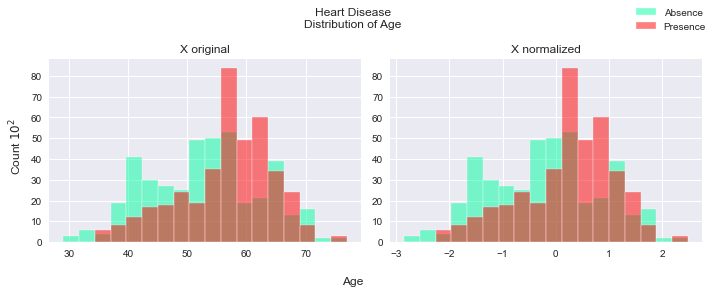

In [19]:
fig, (main, scaled) = plt.subplots(1, 2, figsize=(10, 4))
fig.suptitle("Heart Disease\nDistribution of Age")
fig.supylabel("Count $10^2$")
fig.supxlabel("Age")

main = sns.histplot(x=X["age"], hue=Y, ax=main, palette=["red", "#00FFA0"])
main.set_title("X original")
main.set_xlabel("")
main.set_ylabel("")
main.get_legend().remove()

scaled = sns.histplot(x=X_scaled["age"], hue=Y, ax=scaled, palette=["red", "#00FFA0"])
scaled.set_title("X normalized")
scaled.set_xlabel("")
scaled.set_ylabel("")
scaled.get_legend().remove()

fig.legend(["Absence", "Presence"])
plt.tight_layout()

In [20]:
X = X_scaled

## 6. Using Logistic Regression

In [69]:
model = LogisticRegression(learning_rate=1, num_iters=360, verbose=True)

## 7. Fitting the training data

In [70]:
model.fit(X, Y)

Iteration | 	Cost	| 	                              W                               	 |      B      |
   36     | 4.50091e-01 | [-0.29793214  0.71202924  0.73516451 -0.54229563 -0.24663018 -0.88430466
 -0.364265    0.01670982] |    -0.00     |
   72     | 4.49943e-01 | [-0.32106177  0.73736475  0.75487683 -0.53166276 -0.24911397 -0.92545218
 -0.37668079  0.01669631] |    -0.00     |
   108    | 4.49941e-01 | [-0.32290458  0.74094554  0.75609569 -0.53020311 -0.24759687 -0.92784196
 -0.37811531  0.01650136] |    -0.00     |
   144    | 4.49941e-01 | [-0.32310905  0.74141646  0.75619788 -0.53001859 -0.24732627 -0.92804615
 -0.37829715  0.01646947] |    -0.00     |
   180    | 4.49941e-01 | [-0.32313427  0.74147763  0.75620876 -0.52999516 -0.24728837 -0.92806853
 -0.37832053  0.01646519] |    -0.00     |
   216    | 4.49941e-01 | [-0.32313748  0.74148555  0.75621007 -0.52999215 -0.24728336 -0.92807127
 -0.37832355  0.01646463] |    -0.00     |
   252    | 4.49941e-01 | [-0.32313789  0.74148

In [71]:
model.accuracy * 100

80.0

Accuracy is quite good!

## 7. Predicting *target* on test data
But before that:
- Selecting useful features
- Normalizing the data

In [72]:
test_data = test_data[features]
test_data, _, _= standardization(test_data)

In [73]:
test_preds = model.predict(test_data)
test_preds

array([1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1,
       1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0,
       0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0,
       1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1,
       1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0,
       1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0,
       0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1,
       0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1,
       1, 0, 1, 1, 1, 0, 1])

In [68]:
test_data.head()

chol   thalach        cp     exang       age       sex  trestbps  \
0 -0.177407  1.291979  1.094764  1.467599 -1.033006  0.712287 -0.104424   
1  1.557309  0.115230  0.097312 -0.681385  0.471932 -1.403928  0.227467   
2 -1.105279 -0.233436 -0.900139  1.467599  1.009410  0.712287  0.448728   
3 -0.621172  0.681813  1.094764 -0.681385  0.471932  0.712287  0.448728   
4  0.367213 -0.407769 -0.900139  1.467599  0.794418  0.712287 -0.657577   

        fbs  
0 -0.405922  
1  2.463527  
2 -0.405922  
3  2.463527  
4 -0.405922

Ok, so now our model is ready!

Let's save the parameters into `model_params.json` file

In [66]:
import json
data = {
    "learning_rate":    model.learning_rate,
    "num_iters":        model.num_iters,
    "weights":          list(model.w_final),
    "bias":             model.intercept
}

with open("./model_params.json", "w") as f:
    json.dump(data, f, indent=4)